Lab Experiment: Backpropagation and Optimization
Objective: To implement a simple neural network from stractch, understanding the backpropagation algorithm and compare the performance of Stochastic GD and Adam Optimizers

Importing Necessary Libraries 

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

setting up random seed for reproductibility

In [20]:
np.random.seed(42)

Generating a dataset of 500 samples

In [21]:
X, y = make_moons(n_samples=500, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

splitting the dataset into training and testing sets

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


Visualize the dataset

Visualizing the synthetic dataset...


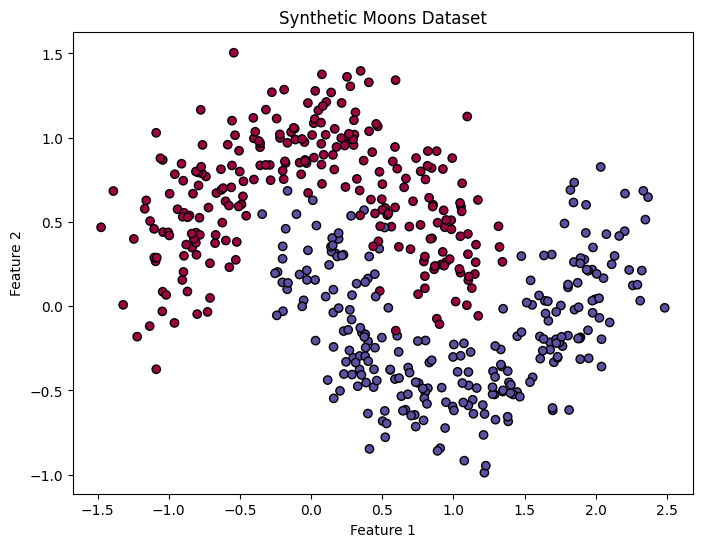

In [23]:
print("Visualizing the synthetic dataset...")
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral, edgecolors='k')
plt.title('Synthetic Moons Dataset')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()


Activation and Loss Function 

In [24]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z):
    s = sigmoid(z)
    return s * (1 - s)

def binary_cross_entropy(y_true, y_pred):
    m = y_true.shape[0]
    # Add a small epsilon to prevent log(0)
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    loss = -1/m * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss

def binary_cross_entropy_derivative(y_true, y_pred):
    epsilon = 1e-15
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return - (y_true / y_pred) + (1 - y_true) / (1 - y_pred)


Neural Network Implementation 

In [25]:
class NeuralNetwork:
    def __init__(self, layer_dims):
        self.parameters = {}
        self.num_layers = len(layer_dims)
        for l in range(1, self.num_layers):
            # Xavier Initialization
            self.parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(1 / layer_dims[l-1])
            self.parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))

    def forward(self, X):
        """Implements the forward pass."""
        caches = []
        A = X.T  # Transpose X to match dimensions (n_features, n_samples)
        L = self.num_layers - 1

        for l in range(1, L + 1):
            A_prev = A
            W = self.parameters['W' + str(l)]
            b = self.parameters['b' + str(l)]
            
            Z = np.dot(W, A_prev) + b
            A = sigmoid(Z)
            
            cache = (A_prev, W, b, Z)
            caches.append(cache)
            
        return A, caches

    def backward(self, AL, Y, caches):
        """Implements the backward pass (backpropagation)."""
        grads = {}
        L = len(caches)
        m = AL.shape[1]
        Y = Y.T 

        dAL = binary_cross_entropy_derivative(Y, AL)
        
        current_cache = caches[L-1]
        A_prev, W, b, Z = current_cache
        
        dZ = dAL * sigmoid_derivative(Z)
        grads['dW' + str(L)] = (1/m) * np.dot(dZ, A_prev.T)
        grads['db' + str(L)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
        dA_prev = np.dot(W.T, dZ)

        for l in reversed(range(L - 1)):
            current_cache = caches[l]
            A_prev, W, b, Z = current_cache
            
            dZ = dA_prev * sigmoid_derivative(Z)
            grads['dW' + str(l + 1)] = (1/m) * np.dot(dZ, A_prev.T)
            grads['db' + str(l + 1)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            dA_prev = np.dot(W.T, dZ)
            
        return grads

Optimization Algorithm

In [26]:
def update_parameters_sgd(parameters, grads, learning_rate):
    L = len(parameters) // 2
    for l in range(1, L + 1):
        parameters['W' + str(l)] -= learning_rate * grads['dW' + str(l)]
        parameters['b' + str(l)] -= learning_rate * grads['db' + str(l)]
    return parameters

def initialize_adam(parameters):
    L = len(parameters) // 2
    v, s = {}, {}
    for l in range(1, L + 1):
        v["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        v["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
        s["dW" + str(l)] = np.zeros(parameters["W" + str(l)].shape)
        s["db" + str(l)] = np.zeros(parameters["b" + str(l)].shape)
    return v, s

def update_parameters_adam(parameters, grads, v, s, t, learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2
    v_corrected, s_corrected = {}, {}

    for l in range(1, L + 1):
        v["dW" + str(l)] = beta1 * v["dW" + str(l)] + (1 - beta1) * grads['dW' + str(l)]
        v["db" + str(l)] = beta1 * v["db" + str(l)] + (1 - beta1) * grads['db' + str(l)]

        v_corrected["dW" + str(l)] = v["dW" + str(l)] / (1 - beta1 ** t)
        v_corrected["db" + str(l)] = v["db" + str(l)] / (1 - beta1 ** t)

        s["dW" + str(l)] = beta2 * s["dW" + str(l)] + (1 - beta2) * np.square(grads['dW' + str(l)])
        s["db" + str(l)] = beta2 * s["db" + str(l)] + (1 - beta2) * np.square(grads['db' + str(l)])

        s_corrected["dW" + str(l)] = s["dW" + str(l)] / (1 - beta2 ** t)
        s_corrected["db" + str(l)] = s["db" + str(l)] / (1 - beta2 ** t)

        parameters["W" + str(l)] -= learning_rate * v_corrected["dW" + str(l)] / (np.sqrt(s_corrected["dW" + str(l)]) + epsilon)
        parameters["b" + str(l)] -= learning_rate * v_corrected["db" + str(l)] / (np.sqrt(s_corrected["db" + str(l)]) + epsilon)
        
    return parameters, v, s

Training the model

In [27]:
def train_model(X, y, layer_dims, optimizer='sgd', learning_rate=0.01, num_epochs=10000, print_cost=True):
    costs = []
    t = 0 # Counter for Adam optimizer
    
    # Initialize model and optimizer parameters
    model = NeuralNetwork(layer_dims)
    if optimizer == 'adam':
        v, s = initialize_adam(model.parameters)
    
    for i in range(num_epochs):
        # Forward propagation
        AL, caches = model.forward(X)
        
        # Compute cost
        cost = binary_cross_entropy(y, AL.T)
        
        # Backward propagation
        grads = model.backward(AL, y, caches)
        
        # Update parameters
        if optimizer == 'sgd':
            model.parameters = update_parameters_sgd(model.parameters, grads, learning_rate)
        elif optimizer == 'adam':
            t += 1 # Increment Adam counter
            model.parameters, v, s = update_parameters_adam(model.parameters, grads, v, s, t, learning_rate)
            
        # Print and store the cost
        if i % 1000 == 0:
            if print_cost:
                print(f"Cost after epoch {i}: {cost:.6f}")
            costs.append(cost)
            
    return model, costs

In [28]:
layer_dims = [X_train.shape[1], 10, 5, 1]

In [29]:
print(" Training with SGD ")
model_sgd, costs_sgd = train_model(X_train, y_train, layer_dims, optimizer='sgd', learning_rate=0.1, num_epochs=20000)

 Training with SGD 
Cost after epoch 0: 0.689131
Cost after epoch 1000: 0.309128
Cost after epoch 2000: 0.291262
Cost after epoch 3000: 0.285424
Cost after epoch 4000: 0.273188
Cost after epoch 5000: 0.234803
Cost after epoch 6000: 0.167852
Cost after epoch 7000: 0.119450
Cost after epoch 8000: 0.096009
Cost after epoch 9000: 0.084395
Cost after epoch 10000: 0.077816
Cost after epoch 11000: 0.073544
Cost after epoch 12000: 0.070419
Cost after epoch 13000: 0.067902
Cost after epoch 14000: 0.065724
Cost after epoch 15000: 0.063744
Cost after epoch 16000: 0.061888
Cost after epoch 17000: 0.060120
Cost after epoch 18000: 0.058424
Cost after epoch 19000: 0.056793


In [30]:
print("\n Training with Adam ")
model_adam, costs_adam = train_model(X_train, y_train, layer_dims, optimizer='adam', learning_rate=0.01, num_epochs=20000)


 Training with Adam 
Cost after epoch 0: 0.708259
Cost after epoch 1000: 0.051568
Cost after epoch 2000: 0.030274
Cost after epoch 3000: 0.022948
Cost after epoch 4000: 0.020951
Cost after epoch 5000: 0.017482
Cost after epoch 6000: 0.015238
Cost after epoch 7000: 0.014250
Cost after epoch 8000: 0.012953
Cost after epoch 9000: 0.010477
Cost after epoch 10000: 0.005339
Cost after epoch 11000: 0.002373
Cost after epoch 12000: 0.001124
Cost after epoch 13000: 0.000533
Cost after epoch 14000: 0.000260
Cost after epoch 15000: 0.000125
Cost after epoch 16000: 0.000061
Cost after epoch 17000: 0.000030
Cost after epoch 18000: 0.000015
Cost after epoch 19000: 0.000007


Plotting the loss curves

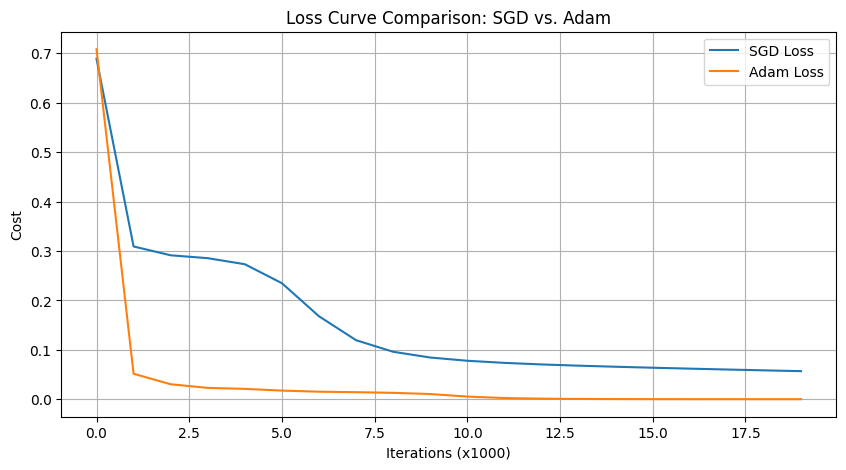

In [31]:
plt.figure(figsize=(10, 5))
plt.plot(np.squeeze(costs_sgd), label='SGD Loss')
plt.plot(np.squeeze(costs_adam), label='Adam Loss')
plt.ylabel('Cost')
plt.xlabel('Iterations (x1000)')
plt.title('Loss Curve Comparison: SGD vs. Adam')
plt.legend()
plt.grid(True)
plt.show()


Helper function to plot decision boundary

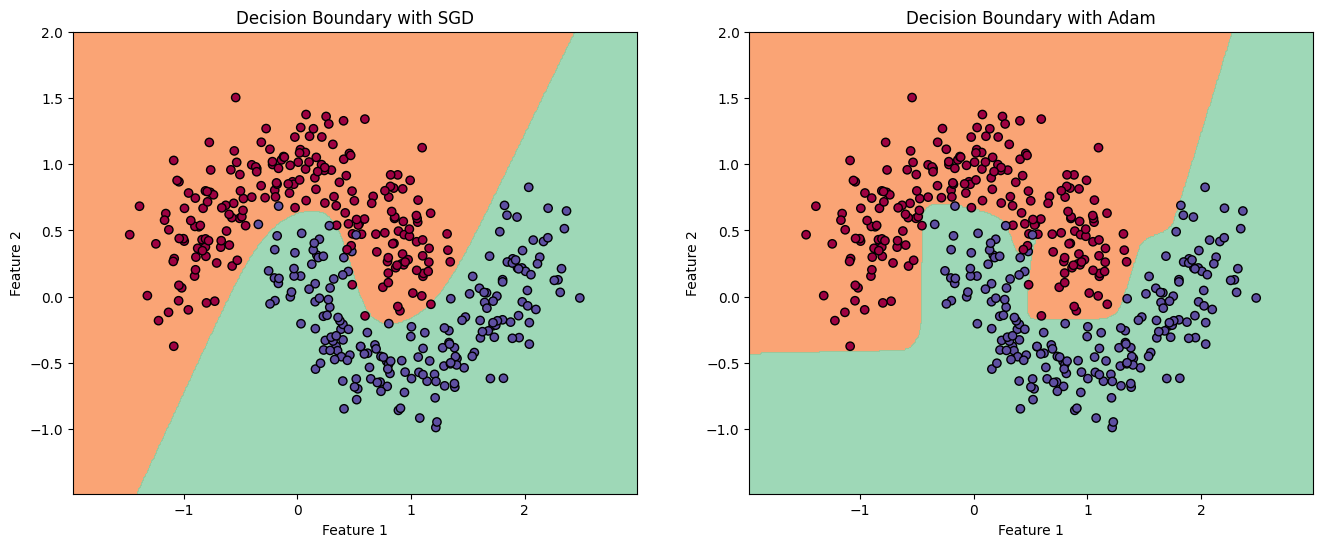

In [32]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    
    # Predict the function value for the whole grid
    Z, _ = model.forward(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z > 0.5, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap=plt.cm.Spectral, edgecolors='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')

# Plot decision boundaries
plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plt.title("Decision Boundary with SGD")
plot_decision_boundary(model_sgd, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Decision Boundary with Adam")
plot_decision_boundary(model_adam, X_train, y_train)

plt.show()

Model Evaluation

In [33]:
def predict(model, X):
    AL, _ = model.forward(X)
    predictions = (AL > 0.5).astype(int)
    return predictions.T


In [34]:
pred_train_sgd = predict(model_sgd, X_train)
pred_test_sgd = predict(model_sgd, X_test)

print("--- SGD Performance ---")
print(f"Train Accuracy: {np.mean(pred_train_sgd == y_train) * 100:.2f}%")
print(f"Test Accuracy:  {np.mean(pred_test_sgd == y_test) * 100:.2f}%")

# --- Evaluate Adam Model ---
pred_train_adam = predict(model_adam, X_train)
pred_test_adam = predict(model_adam, X_test)

print("\n--- Adam Performance ---")
print(f"Train Accuracy: {np.mean(pred_train_adam == y_train) * 100:.2f}%")
print(f"Test Accuracy:  {np.mean(pred_test_adam == y_test) * 100:.2f}%")

--- SGD Performance ---
Train Accuracy: 98.00%
Test Accuracy:  99.00%

--- Adam Performance ---
Train Accuracy: 100.00%
Test Accuracy:  98.00%
